### YOGO output visualization / processing

The purpose of this notebook is to visualize YOGO's output and any post-processing steps.

Prerequisites 
- `pip install yogo` (I think once you do this once, it should be retained anytime you open the notebook again in Bruno)
- Have a GPU available (the command in the cell below, `nvidia-smi` will fail if you don't have a GPU available)

This notebook lets you:
- Pick a model (change the `MODEL_PTH` constant to a model path, some model paths are already defined as constants (e.g `BRISK_SWEEP`). For example, you could do `MODEL_PTH = Path(BRISK_SWEEP)`
- Pick a zarr file and image index on which to run the model. Choose the zarr file by changing the `ZARR_PATH` constant. Some datasets are already defined, e.g `HIGH_HEMAT`, so you could set `ZARR_PATH = Path(HIGH_HEMAT)`
- Pick an image index (change the `IMG_INDEX` constant). Perhaps obvious, but this `IMG_INDEX` value can't be bigger than however many images are in the zarr file.

The notebook will then output
- A preview of the image you chose
- The objectness and confidence grids for the given image
- Histograms of the objectness and confidence values for the given image

Example output:
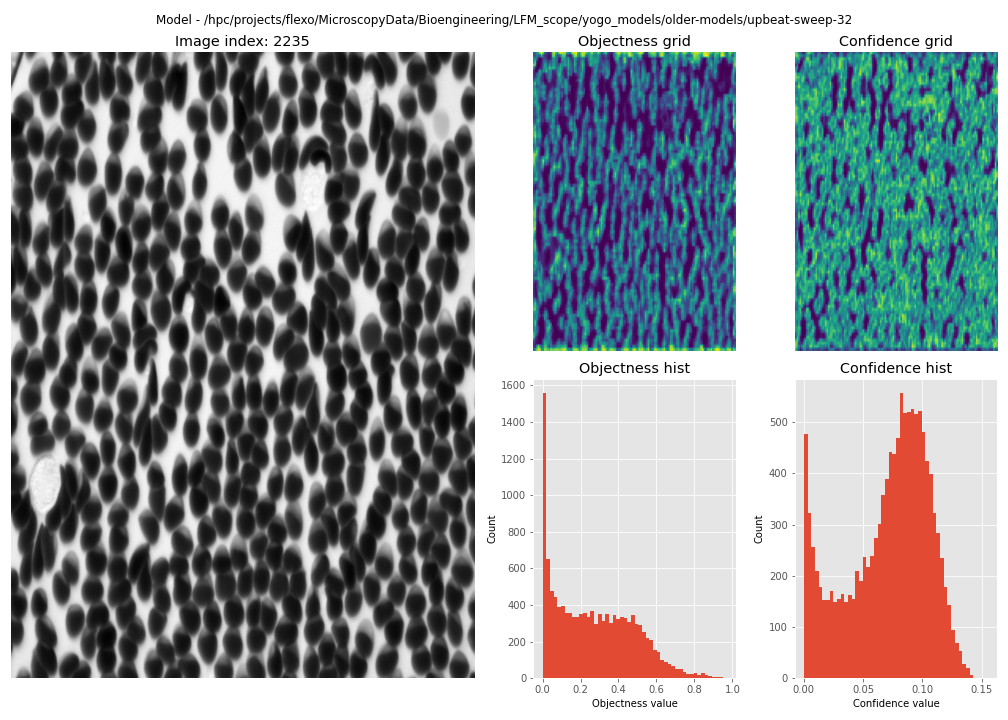


IJ WIP
- Add NMS and visualize
- Add stuck cell detection and visualize

In [16]:
!nvidia-smi

Thu Jul 27 09:04:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:01:00.0 Off |                  Off |
| 30%   30C    P8    22W / 300W |   1527MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import zarr

from yogo.utils.helpers import load_model, get_img_from_zarr_in_torch_format

In [18]:
# MODELS
BRISK_SWEEP = "/hpc/projects/flexo/MicroscopyData/Bioengineering/LFM_scope/yogo_models/older-models/brisk-sweep-9/best.pth"
UPBEAT_SWEEP = "/hpc/projects/flexo/MicroscopyData/Bioengineering/LFM_scope/yogo_models/older-models/upbeat-sweep-32/best.pth"
CLASSIC_FROG = "/hpc/projects/flexo/MicroscopyData/Bioengineering/LFM_scope/yogo_models/classic-frog-1679/best.pth"

# DATASETS
HIGH_HEMAT = "/hpc/projects/flexo/MicroscopyData/Bioengineering/LFM_scope/misc/high_hemat/2023-07-13-150543/2023-07-13-150641_/2023-07-13-150641_.zip"

##### Set up - load model and zarr

In [19]:
MODEL_PTH = Path(CLASSIC_FROG)
ZARR_PATH = Path(HIGH_HEMAT)
IMG_INDEX = 2235

print(f"Loading model: {MODEL_PTH.parents[0].stem}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model(MODEL_PTH, device)

print(f"Loading zarr: {ZARR_PATH}")
zf = zarr.open(ZARR_PATH, "r")
img = zf[:, :, IMG_INDEX]
img_torch = get_img_from_zarr_in_torch_format(zf, IMG_INDEX)

Loading model: classic-frog-1679
Loading zarr: /hpc/projects/flexo/MicroscopyData/Bioengineering/LFM_scope/misc/high_hemat/2023-07-13-150543/2023-07-13-150641_/2023-07-13-150641_.zip


##### Run model on the image above

In [20]:
predictions = model(img_torch)

torch.Size([1, 12, 97, 129])


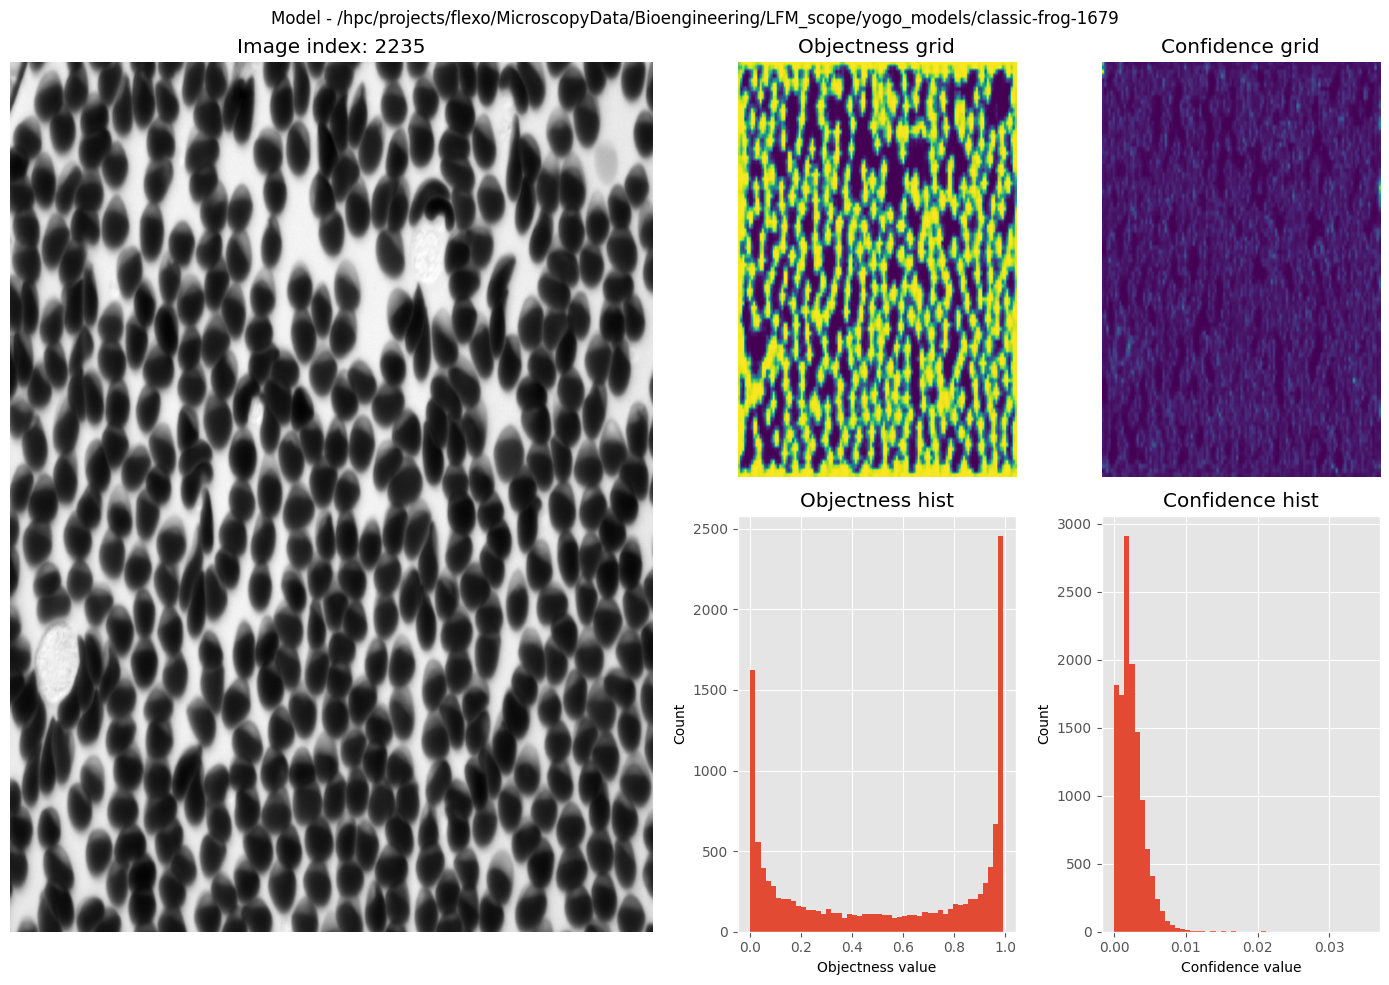

In [23]:
bs, dims, sx, sy = predictions.shape
print(predictions.shape)

arr = predictions.cpu().detach().numpy()
objectness = arr[0, 5, :, :]
confidences = arr[0, 6, :, :]

with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(14, 10))
    plt.suptitle(f"Model - {MODEL_PTH.parent}")

    gs = fig.add_gridspec(2, 4)
    ax1 = fig.add_subplot(gs[:, :2])
    ax2 = fig.add_subplot(gs[0, 2])
    ax3 = fig.add_subplot(gs[0, 3])
    ax4 = fig.add_subplot(gs[1, 2])
    ax5 = fig.add_subplot(gs[1, 3])

    ax1.imshow(img, cmap="gray", aspect="auto")
    ax1.set_title(f"Image index: {IMG_INDEX}")
    ax1.axis("off")

    ax2.imshow(objectness, aspect="auto")
    ax2.set_title("Objectness grid")
    ax2.axis("off")

    ax3.imshow(confidences, aspect="auto")
    ax3.set_title("Confidence grid")
    ax3.axis("off")

    ax4.hist(objectness.flatten(), bins=50)
    ax4.set_title("Objectness hist")
    ax4.set_xlabel("Objectness value")
    ax4.set_ylabel("Count")

    ax5.set_title("Confidence hist")
    ax5.set_xlabel("Confidence value")
    ax5.set_ylabel("Count")
    _ = ax5.hist(confidences.flatten(), bins=50)
    plt.tight_layout()

In [22]:
reshaped_preds = torch.reshape(predictions, (12, sx * sy))
print(reshaped_preds.shape)

torch.Size([12, 12513])
